<a href="https://colab.research.google.com/github/badboizalai/Lung-Cancer-Classification/blob/main/Lung_Cancer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!mkdir -p sam_checkpoints
!wget -O sam_checkpoints/sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sjm9pnzo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sjm9pnzo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=dabd5a5df294675d9f50d8fdee9b5f3d80c64771569b6ad895213e667a8dcb88
  Stored in directory: /tmp/pip-ephem-wheel-cache-avky0bxw/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-03-11 05:23:38--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.22

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from segment_anything import sam_model_registry, SamPredictor

from scipy.ndimage import binary_fill_holes, binary_dilation
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Activation
)
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
import shutil

source_dir = '/content/drive/MyDrive/DAT/Augmented_Data'

destination_dir = '/content/Augmented_Data'

shutil.copytree(source_dir, destination_dir)


'/content/Augmented_Data'

In [ ]:
import os

files_in_colab = os.listdir(destination_dir)
files_in_colab


['Normal cases', 'Malignant cases', 'Bengin cases']

In [ ]:
import os
import pandas as pd

directory = "/content/Augmented_Data"
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

filepaths = []
labels = []

for category in categories:
    path = os.path.join(directory, category)
    if os.path.exists(path):
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            filepaths.append(filepath)
            labels.append(category)
    else:
        print(f"Directory not found: {path}")

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_df = pd.DataFrame({"filepaths": Fseries, "labels": Lseries})

print(Lung_df.head())

                                           filepaths        labels
0  /content/Augmented_Data/Bengin cases/aug_0_mas...  Bengin cases
1  /content/Augmented_Data/Bengin cases/aug_4_ori...  Bengin cases
2  /content/Augmented_Data/Bengin cases/aug_5_ori...  Bengin cases
3  /content/Augmented_Data/Bengin cases/aug_2_mas...  Bengin cases
4  /content/Augmented_Data/Bengin cases/aug_4_ori...  Bengin cases


In [ ]:
train_list, val_list = train_test_split(Lung_df, train_size=0.8, shuffle=True, random_state=42)
print(f"Number of train samples: {len(train_list)}")
print(f"Number of test samples: {len(val_list)}")

Number of train samples: 4800
Number of test samples: 1200


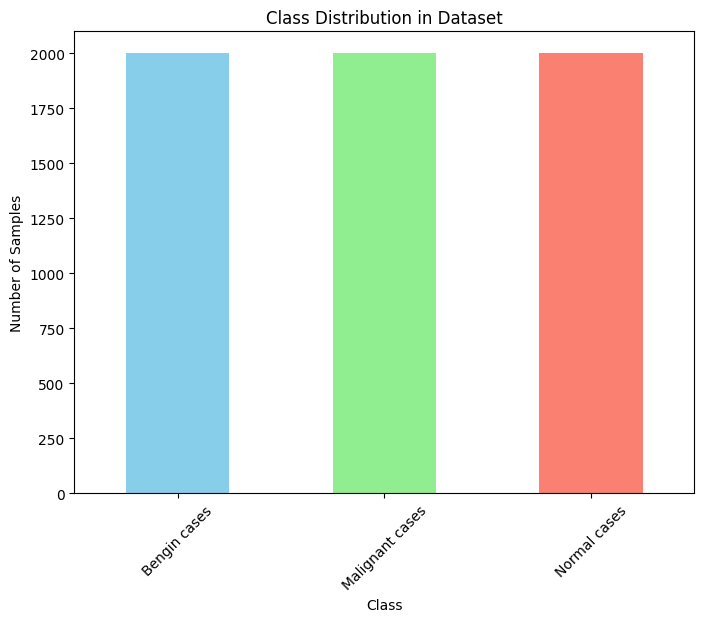

In [ ]:
def visualize_data_balance(labels, title="Class Distribution"):
    class_counts = pd.Series(labels).value_counts()

    plt.figure(figsize=(8, 6))
    class_counts.plot(kind="bar", color=["skyblue", "lightgreen", "salmon"])
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

visualize_data_balance(labels, title="Class Distribution in Dataset")

In [ ]:
import os
import pandas as pd

directory = "/content/drive/MyDrive/DAT/TestData/test"
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

filepaths = []
labels = []

for category in categories:
    path = os.path.join(directory, category)
    if os.path.exists(path):
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            filepaths.append(filepath)
            labels.append(category)
    else:
        print(f"Directory not found: {path}")

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
test_df = pd.DataFrame({"filepaths": Fseries, "labels": Lseries})

print(test_df.head())

                                           filepaths        labels
0  /content/drive/MyDrive/DAT/TestData/test/Bengi...  Bengin cases
1  /content/drive/MyDrive/DAT/TestData/test/Bengi...  Bengin cases
2  /content/drive/MyDrive/DAT/TestData/test/Bengi...  Bengin cases
3  /content/drive/MyDrive/DAT/TestData/test/Bengi...  Bengin cases
4  /content/drive/MyDrive/DAT/TestData/test/Bengi...  Bengin cases


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_list,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_list,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Found 110 validated image filenames belonging to 3 classes.


# MobileNet

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5346 - loss: 1.0087
Epoch 1: val_loss improved from inf to 0.65328, saving model to best_mobilenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 481ms/step - accuracy: 0.5350 - loss: 1.0077 - val_accuracy: 0.6892 - val_loss: 0.6533 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7122 - loss: 0.6423
Epoch 2: val_loss improved from 0.65328 to 0.54339, saving model to best_mobilenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 445ms/step - accuracy: 0.7123 - loss: 0.6422 - val_accuracy: 0.7408 - val_loss: 0.5434 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7365 - loss: 0.5816
Epoch 3: val_loss improved from 0.54339 to 0.49769, saving model to best_mobilenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 445ms/step - accuracy: 0.7366 - loss: 0.5815 - val_accuracy: 0.7754 - val_loss: 0.4977 - learning_rate: 1.0000e-04
Epoch 4/50


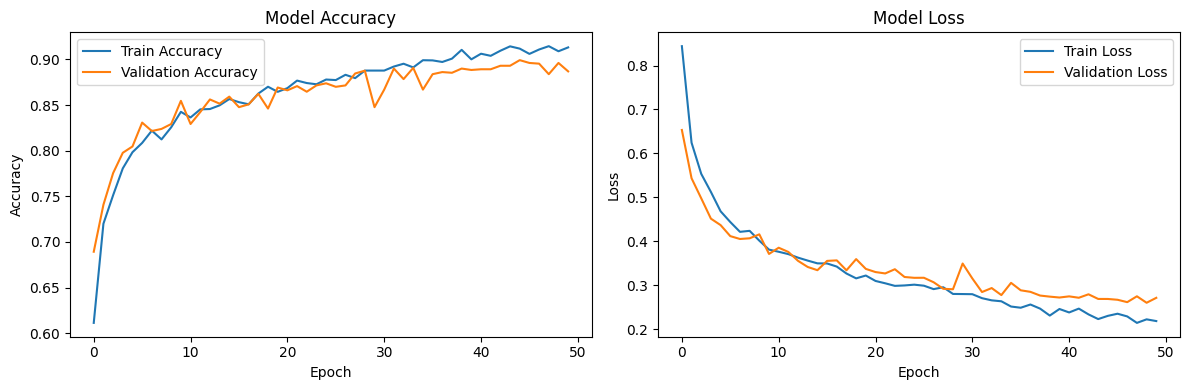

In [ ]:
from tensorflow.keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(len(categories), activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = mobilenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Found 361 validated image filenames belonging to 3 classes.


Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/mobilenet_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/mobilenet_weights.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step
Accuracy: 0.9445983379501385
Precision: 0.9464844287909163
Recall: 0.9445983379501385
F1-score: 0.9447237156196381


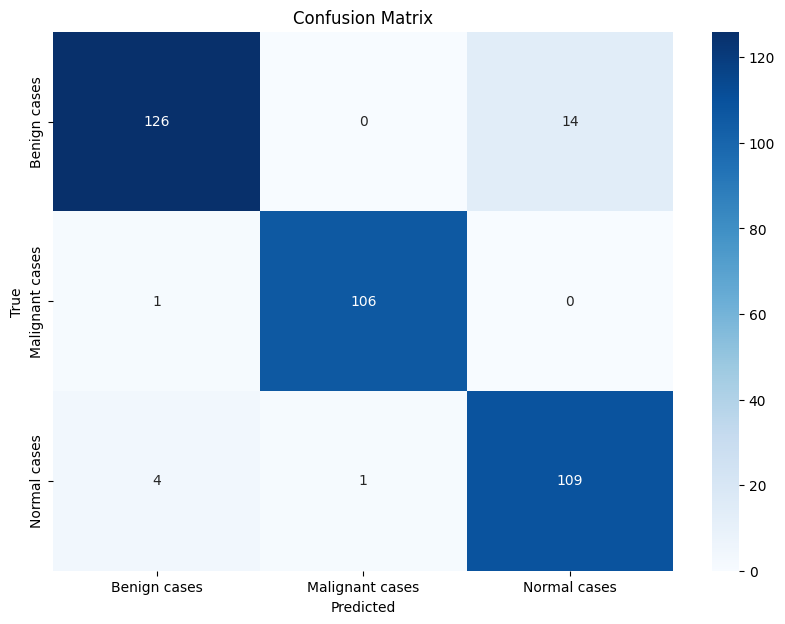

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "mobilenet_model.h5")
mobilenet_model.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "mobilenet_weights.weights.h5")
mobilenet_model.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = mobilenet_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGG116

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.4577 - loss: 1.0829
Epoch 1: val_loss improved from inf to 0.97229, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 729ms/step - accuracy: 0.4581 - loss: 1.0822 - val_accuracy: 0.5731 - val_loss: 0.9723 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.6255 - loss: 0.8020
Epoch 2: val_loss improved from 0.97229 to 0.83042, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 576ms/step - accuracy: 0.6255 - loss: 0.8019 - val_accuracy: 0.6062 - val_loss: 0.8304 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.6676 - loss: 0.7349
Epoch 3: val_loss improved from 0.83042 to 0.70608, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 618ms/step - accuracy: 0.6676 - loss: 0.7349 - val_accuracy: 0.6615 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6857 - loss: 0.6987
Epoch 4: val_loss improved from 0.70608 to 0.68574, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 575ms/step - accuracy: 0.6857 - loss: 0.6987 - val_accuracy: 0.6715 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6971 - loss: 0.6613
Epoch 5: val_loss improved from 0.68574 to 0.60926, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 547ms/step - accuracy: 0.6971 - loss: 0.6612 - val_accuracy: 0.7031 - val_loss: 0.6093 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7188 - loss: 0.6257
Epoch 6: val_loss did not improve from 0.60926
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.7188 - loss: 0.6257 - val_accuracy: 0.6962 - val_loss: 0.6103 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7175 - loss: 0.6179
Epoch 7: val_loss improved from 0.60926 to 0.53615, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 508ms/step - accuracy: 0.7175 - loss: 0.6178 - val_accuracy: 0.7477 - val_loss: 0.5361 - learning_rate: 1.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7270 - loss: 0.6075
Epoch 8: val_loss improved from 0.53615 to 0.53048, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 505ms/step - accuracy: 0.7270 - loss: 0.6074 - val_accuracy: 0.7477 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7476 - loss: 0.5835
Epoch 9: val_loss did not improve from 0.53048
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.7476 - loss: 0.5834 - val_accuracy: 0.7677 - val_loss: 0.5398 - learning_rate: 1.0000e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7421 - loss: 0.5802
Epoch 10: val_loss improved from 0.53048 to 0.49818, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.7422 - loss: 0.5801 - val_accuracy: 0.7762 - val_loss: 0.4982 - learning_rate: 1.0000e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7505 - loss: 0.5598
Epoch 11: val_loss did not improve from 0.49818
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 499ms/step - accuracy: 0.7505 - loss: 0.5598 - val_accuracy: 0.7654 - val_loss: 0.5266 - learning_rate: 1.0000e-04
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7553 - loss: 0.5414
Epoch 12: val_loss improved from 0.49818 to 0.48856, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 504ms/step - accuracy: 0.7553 - loss: 0.5414 - val_accuracy: 0.7715 - val_loss: 0.4886 - learning_rate: 1.0000e-04
Epoch 13/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7652 - loss: 0.5395
Epoch 13: val_loss improved from 0.48856 to 0.48208, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 509ms/step - accuracy: 0.7652 - loss: 0.5395 - val_accuracy: 0.7785 - val_loss: 0.4821 - learning_rate: 1.0000e-04
Epoch 14/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7663 - loss: 0.5254
Epoch 14: val_loss improved from 0.48208 to 0.46476, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.7663 - loss: 0.5254 - val_accuracy: 0.7992 - val_loss: 0.4648 - learning_rate: 1.0000e-04
Epoch 15/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7935 - loss: 0.4996
Epoch 15: val_loss improved from 0.46476 to 0.45785, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 517ms/step - accuracy: 0.7934 - loss: 0.4997 - val_accuracy: 0.8008 - val_loss: 0.4578 - learning_rate: 1.0000e-04
Epoch 16/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7764 - loss: 0.5066
Epoch 16: val_loss did not improve from 0.45785
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 508ms/step - accuracy: 0.7764 - loss: 0.5066 - val_accuracy: 0.7662 - val_loss: 0.5155 - learning_rate: 1.0000e-04
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7855 - loss: 0.4896
Epoch 17: val_loss improved from 0.45785 to 0.45617, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.7855 - loss: 0.4897 - val_accuracy: 0.7915 - val_loss: 0.4562 - learning_rate: 1.0000e-04
Epoch 18/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7823 - loss: 0.5005
Epoch 18: val_loss improved from 0.45617 to 0.43679, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.7824 - loss: 0.5004 - val_accuracy: 0.8062 - val_loss: 0.4368 - learning_rate: 1.0000e-04
Epoch 19/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7895 - loss: 0.5049
Epoch 19: val_loss did not improve from 0.43679
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.7895 - loss: 0.5049 - val_accuracy: 0.7662 - val_loss: 0.4963 - learning_rate: 1.0000e-04
Epoch 20/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7822 - loss: 0.5008
Epoch 20: val_loss improved from 0.43679 to 0.42666, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 503ms/step - accuracy: 0.7822 - loss: 0.5008 - val_accuracy: 0.8100 - val_loss: 0.4267 - learning_rate: 1.0000e-04
Epoch 21/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7857 - loss: 0.4975
Epoch 21: val_loss did not improve from 0.42666
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.7857 - loss: 0.4975 - val_accuracy: 0.8015 - val_loss: 0.4389 - learning_rate: 1.0000e-04
Epoch 22/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.7993 - loss: 0.4755
Epoch 22: val_loss did not improve from 0.42666
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 539ms/step - accuracy: 0.7993 - loss: 0.4756 - val_accuracy: 0.8031 - val_loss: 0.4330 - learning_rate: 1.0000e-04
Epoch 23/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7886 - loss: 0.4696
Epoch 23: val_loss improved from 0.42666 to 0.41894, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 506ms/step - accuracy: 0.7886 - loss: 0.4696 - val_accuracy: 0.8208 - val_loss: 0.4189 - learning_rate: 1.0000e-04
Epoch 24/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7845 - loss: 0.4854
Epoch 24: val_loss did not improve from 0.41894
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 511ms/step - accuracy: 0.7846 - loss: 0.4854 - val_accuracy: 0.8008 - val_loss: 0.4394 - learning_rate: 1.0000e-04
Epoch 25/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7829 - loss: 0.4837
Epoch 25: val_loss did not improve from 0.41894
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.7829 - loss: 0.4837 - val_accuracy: 0.7900 - val_loss: 0.4377 - learning_rate: 1.0000e-04
Epoch 26/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8209 - loss: 0.4456
Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 26: val_loss did not improve from 0.41894
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 518ms/step - accuracy: 0.8208 - 

163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 509ms/step - accuracy: 0.8002 - loss: 0.4631 - val_accuracy: 0.8262 - val_loss: 0.4017 - learning_rate: 5.0000e-05
Epoch 28/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8015 - loss: 0.4585
Epoch 28: val_loss did not improve from 0.40168
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 512ms/step - accuracy: 0.8014 - loss: 0.4586 - val_accuracy: 0.8177 - val_loss: 0.4099 - learning_rate: 5.0000e-05
Epoch 29/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8056 - loss: 0.4575
Epoch 29: val_loss did not improve from 0.40168
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 530ms/step - accuracy: 0.8056 - loss: 0.4575 - val_accuracy: 0.8292 - val_loss: 0.4032 - learning_rate: 5.0000e-05
Epoch 30/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8058 - loss: 0.4565
Epoch 30: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 30: val_loss did not improve from 0.40168
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.8058 - l

163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 508ms/step - accuracy: 0.8024 - loss: 0.4514 - val_accuracy: 0.8262 - val_loss: 0.3980 - learning_rate: 2.5000e-05
Epoch 33/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7979 - loss: 0.4714
Epoch 33: val_loss did not improve from 0.39803
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 498ms/step - accuracy: 0.7979 - loss: 0.4713 - val_accuracy: 0.8300 - val_loss: 0.3984 - learning_rate: 2.5000e-05
Epoch 34/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8056 - loss: 0.4611
Epoch 34: val_loss improved from 0.39803 to 0.39110, saving model to best_vgg16_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.8056 - loss: 0.4611 - val_accuracy: 0.8415 - val_loss: 0.3911 - learning_rate: 2.5000e-05
Epoch 35/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8082 - loss: 0.4482
Epoch 35: val_loss did not improve from 0.39110
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.8082 - loss: 0.4483 - val_accuracy: 0.8385 - val_loss: 0.3926 - learning_rate: 2.5000e-05
Epoch 36/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8024 - loss: 0.4510
Epoch 36: val_loss did not improve from 0.39110
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.8024 - loss: 0.4510 - val_accuracy: 0.8292 - val_loss: 0.3972 - learning_rate: 2.5000e-05
Epoch 37/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7992 - loss: 0.4547
Epoch 37: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 37: val_loss did not improve from 0.39110
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.7993 - lo

163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 498ms/step - accuracy: 0.8068 - loss: 0.4426 - val_accuracy: 0.8331 - val_loss: 0.3894 - learning_rate: 1.2500e-05
Epoch 40/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8048 - loss: 0.4595
Epoch 40: val_loss did not improve from 0.38939
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 497ms/step - accuracy: 0.8049 - loss: 0.4594 - val_accuracy: 0.8269 - val_loss: 0.3916 - learning_rate: 1.2500e-05
Epoch 41/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8101 - loss: 0.4428
Epoch 41: val_loss did not improve from 0.38939
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 513ms/step - accuracy: 0.8101 - loss: 0.4428 - val_accuracy: 0.8292 - val_loss: 0.3924 - learning_rate: 1.2500e-05
Epoch 42/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8243 - loss: 0.4416
Epoch 42: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 42: val_loss did not improve from 0.38939
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 495ms/step - accuracy: 0.8243 - l

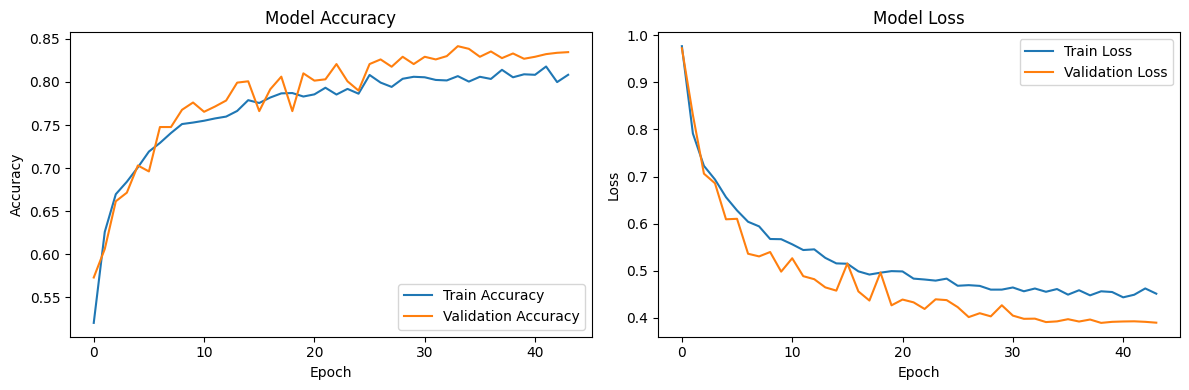

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(len(categories), activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = vgg16_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = vgg16_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/vgg16_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/vgg16_weights.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step
Accuracy: 0.853185595567867
Precision: 0.8557315684764837
Recall: 0.853185595567867
F1-score: 0.8531932395970059


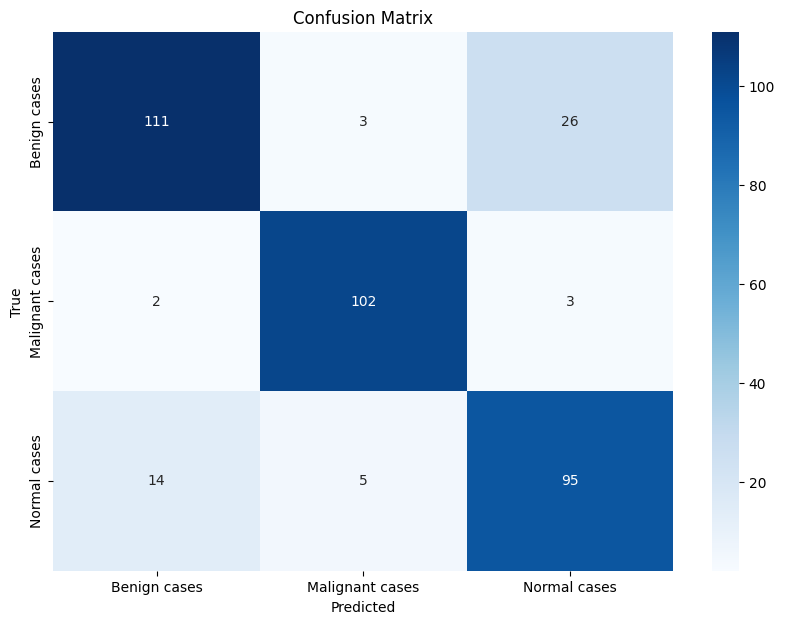

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "vgg16_model.h5")
vgg16_model.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "vgg16_weights.weights.h5")
vgg16_model.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = vgg16_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Densenet121

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4425 - loss: 1.2294
Epoch 1: val_loss improved from inf to 0.87132, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 688ms/step - accuracy: 0.4429 - loss: 1.2284 - val_accuracy: 0.5692 - val_loss: 0.8713 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6371 - loss: 0.7819
Epoch 2: val_loss improved from 0.87132 to 0.64805, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 477ms/step - accuracy: 0.6371 - loss: 0.7818 - val_accuracy: 0.7077 - val_loss: 0.6481 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6739 - loss: 0.7095
Epoch 3: val_loss improved from 0.64805 to 0.58605, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 464ms/step - accuracy: 0.6740 - loss: 0.7093 - val_accuracy: 0.7354 - val_loss: 0.5861 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7200 - loss: 0.6467
Epoch 4: val_loss improved from 0.58605 to 0.55680, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.7200 - loss: 0.6466 - val_accuracy: 0.7508 - val_loss: 0.5568 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7474 - loss: 0.6000
Epoch 5: val_loss improved from 0.55680 to 0.53411, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 456ms/step - accuracy: 0.7474 - loss: 0.6000 - val_accuracy: 0.7562 - val_loss: 0.5341 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7564 - loss: 0.5565
Epoch 6: val_loss improved from 0.53411 to 0.50607, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - accuracy: 0.7564 - loss: 0.5566 - val_accuracy: 0.7677 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7493 - loss: 0.5604
Epoch 7: val_loss improved from 0.50607 to 0.47435, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.7494 - loss: 0.5603 - val_accuracy: 0.7915 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7676 - loss: 0.5435
Epoch 8: val_loss improved from 0.47435 to 0.47409, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.7676 - loss: 0.5434 - val_accuracy: 0.7869 - val_loss: 0.4741 - learning_rate: 1.0000e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7914 - loss: 0.4985
Epoch 9: val_loss improved from 0.47409 to 0.44767, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 462ms/step - accuracy: 0.7914 - loss: 0.4985 - val_accuracy: 0.8015 - val_loss: 0.4477 - learning_rate: 1.0000e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7891 - loss: 0.4929
Epoch 10: val_loss improved from 0.44767 to 0.43408, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 482ms/step - accuracy: 0.7891 - loss: 0.4929 - val_accuracy: 0.8085 - val_loss: 0.4341 - learning_rate: 1.0000e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8032 - loss: 0.4682
Epoch 11: val_loss improved from 0.43408 to 0.42307, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.8032 - loss: 0.4683 - val_accuracy: 0.8185 - val_loss: 0.4231 - learning_rate: 1.0000e-04
Epoch 12/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7984 - loss: 0.4764
Epoch 12: val_loss did not improve from 0.42307
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - accuracy: 0.7983 - loss: 0.4765 - val_accuracy: 0.7946 - val_loss: 0.4364 - learning_rate: 1.0000e-04
Epoch 13/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7903 - loss: 0.4898
Epoch 13: val_loss improved from 0.42307 to 0.41433, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 480ms/step - accuracy: 0.7903 - loss: 0.4897 - val_accuracy: 0.8254 - val_loss: 0.4143 - learning_rate: 1.0000e-04
Epoch 14/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8088 - loss: 0.4590
Epoch 14: val_loss did not improve from 0.41433
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 459ms/step - accuracy: 0.8088 - loss: 0.4590 - val_accuracy: 0.8092 - val_loss: 0.4220 - learning_rate: 1.0000e-04
Epoch 15/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8139 - loss: 0.4411
Epoch 15: val_loss did not improve from 0.41433
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.8139 - loss: 0.4411 - val_accuracy: 0.8177 - val_loss: 0.4154 - learning_rate: 1.0000e-04
Epoch 16/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8060 - loss: 0.4598
Epoch 16: val_loss improved from 0.41433 to 0.41136, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.8060 - loss: 0.4598 - val_accuracy: 0.8146 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8119 - loss: 0.4343
Epoch 17: val_loss improved from 0.41136 to 0.39400, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.8120 - loss: 0.4344 - val_accuracy: 0.8200 - val_loss: 0.3940 - learning_rate: 1.0000e-04
Epoch 18/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8140 - loss: 0.4356
Epoch 18: val_loss improved from 0.39400 to 0.38084, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.8140 - loss: 0.4356 - val_accuracy: 0.8300 - val_loss: 0.3808 - learning_rate: 1.0000e-04
Epoch 19/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8229 - loss: 0.4259
Epoch 19: val_loss did not improve from 0.38084
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 447ms/step - accuracy: 0.8229 - loss: 0.4259 - val_accuracy: 0.8369 - val_loss: 0.3889 - learning_rate: 1.0000e-04
Epoch 20/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8236 - loss: 0.4157
Epoch 20: val_loss improved from 0.38084 to 0.36777, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.8235 - loss: 0.4158 - val_accuracy: 0.8400 - val_loss: 0.3678 - learning_rate: 1.0000e-04
Epoch 21/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8299 - loss: 0.4109
Epoch 21: val_loss improved from 0.36777 to 0.36588, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 468ms/step - accuracy: 0.8299 - loss: 0.4109 - val_accuracy: 0.8431 - val_loss: 0.3659 - learning_rate: 1.0000e-04
Epoch 22/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8255 - loss: 0.4174
Epoch 22: val_loss improved from 0.36588 to 0.36006, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - accuracy: 0.8255 - loss: 0.4174 - val_accuracy: 0.8469 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 23/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8329 - loss: 0.4026
Epoch 23: val_loss did not improve from 0.36006
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 452ms/step - accuracy: 0.8329 - loss: 0.4027 - val_accuracy: 0.8392 - val_loss: 0.3739 - learning_rate: 1.0000e-04
Epoch 24/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8273 - loss: 0.4099
Epoch 24: val_loss did not improve from 0.36006
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 468ms/step - accuracy: 0.8272 - loss: 0.4100 - val_accuracy: 0.8454 - val_loss: 0.3835 - learning_rate: 1.0000e-04
Epoch 25/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8412 - loss: 0.3918
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 25: val_loss did not improve from 0.36006
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 452ms/step - accuracy: 0.8412 - lo

163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.8409 - loss: 0.3818 - val_accuracy: 0.8608 - val_loss: 0.3383 - learning_rate: 5.0000e-05
Epoch 27/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8446 - loss: 0.3752
Epoch 27: val_loss improved from 0.33826 to 0.33711, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.8445 - loss: 0.3753 - val_accuracy: 0.8608 - val_loss: 0.3371 - learning_rate: 5.0000e-05
Epoch 28/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8381 - loss: 0.3937
Epoch 28: val_loss did not improve from 0.33711
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.8382 - loss: 0.3937 - val_accuracy: 0.8631 - val_loss: 0.3372 - learning_rate: 5.0000e-05
Epoch 29/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8478 - loss: 0.3758
Epoch 29: val_loss improved from 0.33711 to 0.33394, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.8477 - loss: 0.3759 - val_accuracy: 0.8592 - val_loss: 0.3339 - learning_rate: 5.0000e-05
Epoch 30/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8423 - loss: 0.3856
Epoch 30: val_loss did not improve from 0.33394
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.8422 - loss: 0.3857 - val_accuracy: 0.8577 - val_loss: 0.3400 - learning_rate: 5.0000e-05
Epoch 31/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8393 - loss: 0.3766
Epoch 31: val_loss did not improve from 0.33394
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 457ms/step - accuracy: 0.8393 - loss: 0.3766 - val_accuracy: 0.8631 - val_loss: 0.3413 - learning_rate: 5.0000e-05
Epoch 32/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8501 - loss: 0.3552
Epoch 32: val_loss improved from 0.33394 to 0.32283, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 465ms/step - accuracy: 0.8501 - loss: 0.3553 - val_accuracy: 0.8592 - val_loss: 0.3228 - learning_rate: 5.0000e-05
Epoch 33/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8325 - loss: 0.3829
Epoch 33: val_loss did not improve from 0.32283
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 469ms/step - accuracy: 0.8325 - loss: 0.3829 - val_accuracy: 0.8662 - val_loss: 0.3247 - learning_rate: 5.0000e-05
Epoch 34/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8491 - loss: 0.3643
Epoch 34: val_loss did not improve from 0.32283
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 450ms/step - accuracy: 0.8491 - loss: 0.3643 - val_accuracy: 0.8646 - val_loss: 0.3254 - learning_rate: 5.0000e-05
Epoch 35/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8468 - loss: 0.3667
Epoch 35: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 35: val_loss did not improve from 0.32283
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 464ms/step - accuracy: 0.8469 - lo

163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 470ms/step - accuracy: 0.8501 - loss: 0.3653 - val_accuracy: 0.8677 - val_loss: 0.3154 - learning_rate: 2.5000e-05
Epoch 37/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8367 - loss: 0.3941
Epoch 37: val_loss did not improve from 0.31544
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 457ms/step - accuracy: 0.8367 - loss: 0.3940 - val_accuracy: 0.8700 - val_loss: 0.3155 - learning_rate: 2.5000e-05
Epoch 38/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8498 - loss: 0.3746
Epoch 38: val_loss improved from 0.31544 to 0.31463, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.8499 - loss: 0.3745 - val_accuracy: 0.8677 - val_loss: 0.3146 - learning_rate: 2.5000e-05
Epoch 39/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8428 - loss: 0.3759
Epoch 39: val_loss did not improve from 0.31463
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.8428 - loss: 0.3759 - val_accuracy: 0.8708 - val_loss: 0.3165 - learning_rate: 2.5000e-05
Epoch 40/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8540 - loss: 0.3645
Epoch 40: val_loss improved from 0.31463 to 0.31379, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 463ms/step - accuracy: 0.8540 - loss: 0.3645 - val_accuracy: 0.8646 - val_loss: 0.3138 - learning_rate: 2.5000e-05
Epoch 41/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8555 - loss: 0.3451
Epoch 41: val_loss improved from 0.31379 to 0.31074, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.8554 - loss: 0.3451 - val_accuracy: 0.8731 - val_loss: 0.3107 - learning_rate: 2.5000e-05
Epoch 42/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8400 - loss: 0.3725
Epoch 42: val_loss did not improve from 0.31074
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 453ms/step - accuracy: 0.8400 - loss: 0.3724 - val_accuracy: 0.8700 - val_loss: 0.3115 - learning_rate: 2.5000e-05
Epoch 43/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8529 - loss: 0.3503
Epoch 43: val_loss improved from 0.31074 to 0.31045, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 467ms/step - accuracy: 0.8529 - loss: 0.3503 - val_accuracy: 0.8754 - val_loss: 0.3105 - learning_rate: 2.5000e-05
Epoch 44/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8559 - loss: 0.3568
Epoch 44: val_loss improved from 0.31045 to 0.30715, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 471ms/step - accuracy: 0.8559 - loss: 0.3568 - val_accuracy: 0.8746 - val_loss: 0.3071 - learning_rate: 2.5000e-05
Epoch 45/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8568 - loss: 0.3363
Epoch 45: val_loss did not improve from 0.30715
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.8568 - loss: 0.3363 - val_accuracy: 0.8762 - val_loss: 0.3075 - learning_rate: 2.5000e-05
Epoch 46/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8538 - loss: 0.3480
Epoch 46: val_loss did not improve from 0.30715
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.8538 - loss: 0.3480 - val_accuracy: 0.8669 - val_loss: 0.3077 - learning_rate: 2.5000e-05
Epoch 47/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8562 - loss: 0.3447
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 47: val_loss improved from 0.30715 to 0.30705, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.8562 - loss: 0.3448 - val_accuracy: 0.8708 - val_loss: 0.3071 - learning_rate: 2.5000e-05
Epoch 48/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8633 - loss: 0.3382
Epoch 48: val_loss did not improve from 0.30705
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 464ms/step - accuracy: 0.8633 - loss: 0.3383 - val_accuracy: 0.8685 - val_loss: 0.3083 - learning_rate: 1.2500e-05
Epoch 49/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8552 - loss: 0.3529
Epoch 49: val_loss improved from 0.30705 to 0.30683, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.8552 - loss: 0.3529 - val_accuracy: 0.8685 - val_loss: 0.3068 - learning_rate: 1.2500e-05
Epoch 50/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8367 - loss: 0.3750
Epoch 50: val_loss improved from 0.30683 to 0.30497, saving model to best_densenet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 477ms/step - accuracy: 0.8368 - loss: 0.3749 - val_accuracy: 0.8708 - val_loss: 0.3050 - learning_rate: 1.2500e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 974ms/step - accuracy: 0.9290 - loss: 0.2252
Test Loss: 0.2134769856929779
Test Accuracy: 0.9279778599739075


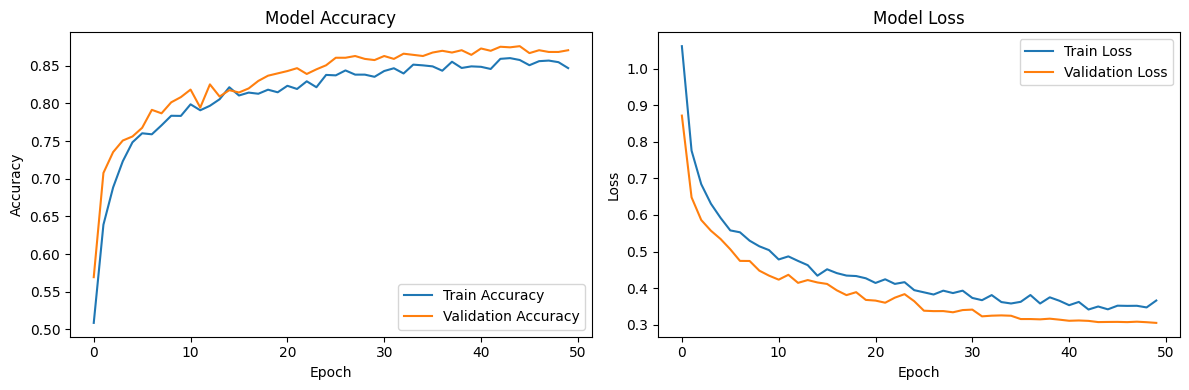

In [ ]:
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(len(categories), activation='softmax')(x)

densenet_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_densenet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = densenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = densenet_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/densenet_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/densenet_weights.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy: 0.9279778393351801
Precision: 0.9280036599408898
Recall: 0.9279778393351801
F1-score: 0.9279807442132986


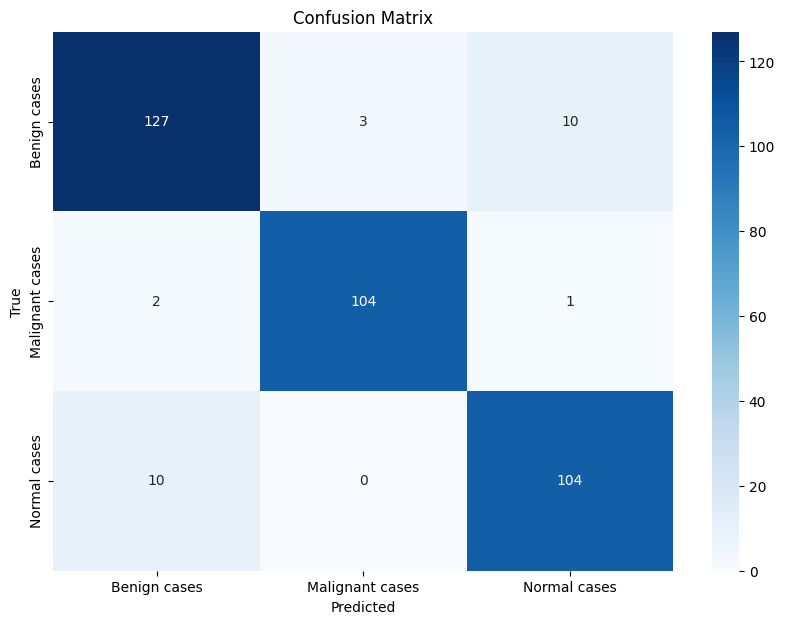

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "densenet_model.h5")
densenet_model.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "densenet_weights.weights.h5")
densenet_model.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = densenet_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Alexnet

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3635 - loss: 2.8123
Epoch 1: val_loss improved from inf to 1.23873, saving model to best_alexnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 525ms/step - accuracy: 0.3636 - loss: 2.8084 - val_accuracy: 0.3408 - val_loss: 1.2387 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4080 - loss: 1.5448
Epoch 2: val_loss improved from 1.23873 to 1.13958, saving model to best_alexnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.4080 - loss: 1.5443 - val_accuracy: 0.3715 - val_loss: 1.1396 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4242 - loss: 1.2523
Epoch 3: val_loss did not improve from 1.13958
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 437ms/step - accuracy: 0.4243 - loss: 1.2521 - val_accuracy: 0.4346 - val_loss: 1.1607 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.4832 - loss: 1.0951
Epoch 4: val_loss improved from 1.13958 to 0.92904, saving model to best_alexnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.4831 - loss: 1.0951 - val_accuracy: 0.5223 - val_loss: 0.9290 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4979 - loss: 1.0326
Epoch 5: val_loss did not improve from 0.92904
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.4979 - loss: 1.0326 - val_accuracy: 0.5054 - val_loss: 0.9713 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5117 - loss: 0.9823
Epoch 6: val_loss did not improve from 0.92904
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 434ms/step - accuracy: 0.5118 - loss: 0.9821 - val_accuracy: 0.5315 - val_loss: 0.9713 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5543 - loss: 0.9053
Epoch 7: val_loss improved from 0.92904 to 0.80135, saving model to best_alexnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 453ms/step - accuracy: 0.5544 - loss: 0.9052 - val_accuracy: 0.5715 - val_loss: 0.8013 - learning_rate: 1.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.5946 - loss: 0.8417
Epoch 8: val_loss improved from 0.80135 to 0.74468, saving model to best_alexnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 491ms/step - accuracy: 0.5946 - loss: 0.8417 - val_accuracy: 0.5992 - val_loss: 0.7447 - learning_rate: 1.0000e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6108 - loss: 0.7955
Epoch 9: val_loss did not improve from 0.74468
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 434ms/step - accuracy: 0.6108 - loss: 0.7955 - val_accuracy: 0.3946 - val_loss: 2.0599 - learning_rate: 1.0000e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6185 - loss: 0.8118
Epoch 10: val_loss did not improve from 0.74468
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.6185 - loss: 0.8117 - val_accuracy: 0.5769 - val_loss: 0.7566 - learning_rate: 1.0000e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6309 - loss: 0.7613
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 11: val_loss did not improve from 0.74468
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.6309 - loss

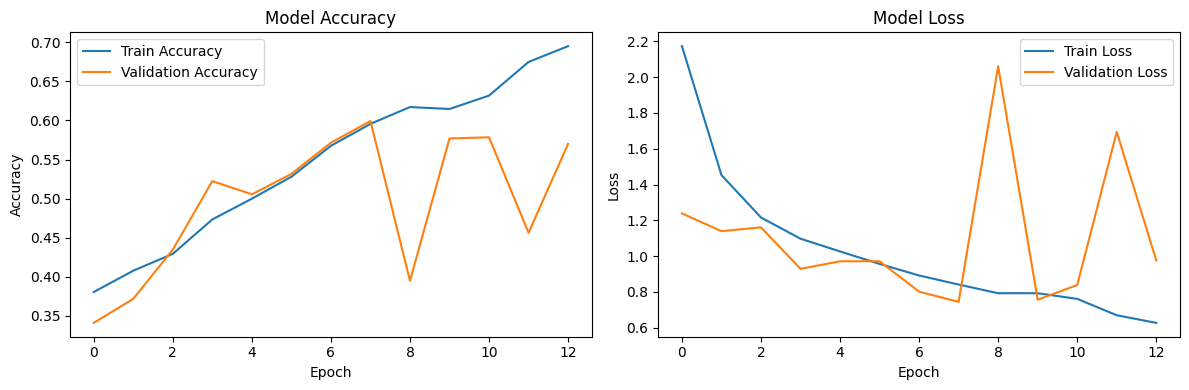

In [ ]:
alexnet_model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(384, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

alexnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_alexnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = alexnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = alexnet_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/alexnet_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/alexnet_weights.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
Accuracy: 0.5872576177285319
Precision: 0.5919458816466219
Recall: 0.5872576177285319
F1-score: 0.5423410031297983


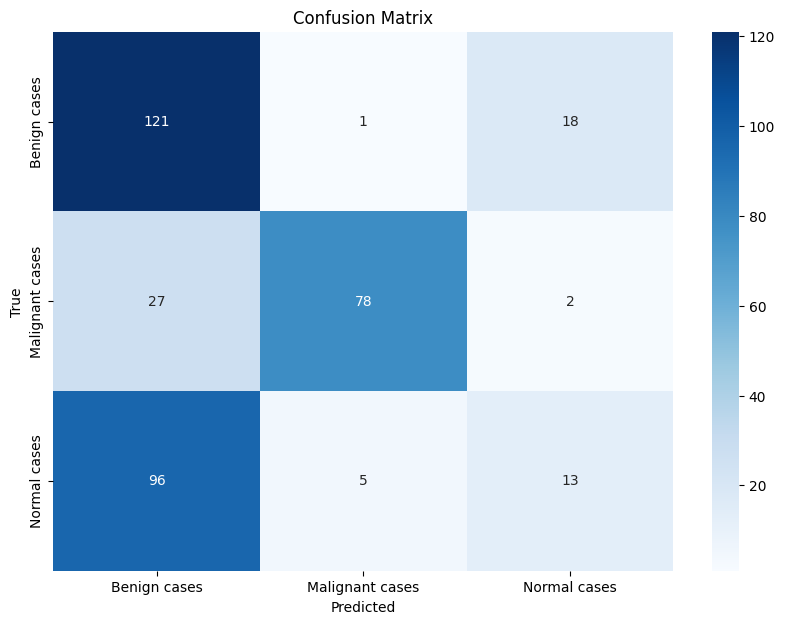

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "alexnet_model.h5")
alexnet_model.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "alexnet_weights.weights.h5")
alexnet_model.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = alexnet_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Resnet

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3861 - loss: 1.1519
Epoch 1: val_loss improved from inf to 1.06912, saving model to best_resnet_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 549ms/step - accuracy: 0.3862 - loss: 1.1516 - val_accuracy: 0.4600 - val_loss: 1.0691 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4453 - loss: 1.0479
Epoch 2: val_loss did not improve from 1.06912
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 450ms/step - accuracy: 0.4454 - loss: 1.0478 - val_accuracy: 0.4538 - val_loss: 1.2045 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4682 - loss: 1.0250
Epoch 3: val_loss did not improve from 1.06912
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 531ms/step - accuracy: 0.4683 - loss: 1.0250 - val_accuracy: 0.3585 - val_loss: 1.4652 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.4864 - loss: 1.0035
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 1.06912
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 549ms/step - accuracy: 0.4864 - loss: 1.

163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 459ms/step - accuracy: 0.4912 - loss: 0.9937 - val_accuracy: 0.5369 - val_loss: 0.9252 - learning_rate: 5.0000e-05
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4976 - loss: 0.9907
Epoch 6: val_loss did not improve from 0.92520
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 443ms/step - accuracy: 0.4976 - loss: 0.9907 - val_accuracy: 0.4185 - val_loss: 1.1350 - learning_rate: 5.0000e-05
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4989 - loss: 0.9926
Epoch 7: val_loss did not improve from 0.92520
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 463ms/step - accuracy: 0.4988 - loss: 0.9926 - val_accuracy: 0.5331 - val_loss: 0.9455 - learning_rate: 5.0000e-05
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4898 - loss: 0.9854
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_loss did not improve from 0.92520
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 449ms/step - accuracy: 0.4898 - loss: 0.

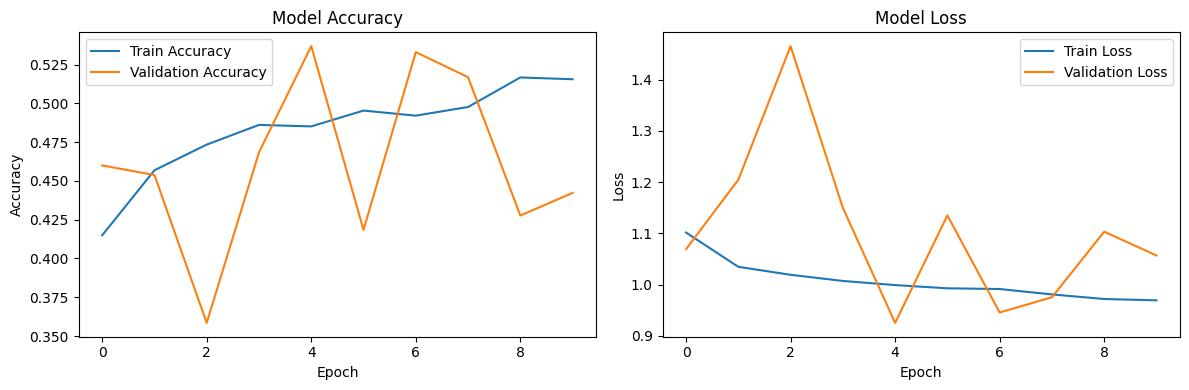

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(len(categories), activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = resnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = resnet_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)



Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/resnet_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/resnet_weights.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step
Accuracy: 0.5429362880886427
Precision: 0.5664257147313478
Recall: 0.5429362880886427
F1-score: 0.5269829701568814


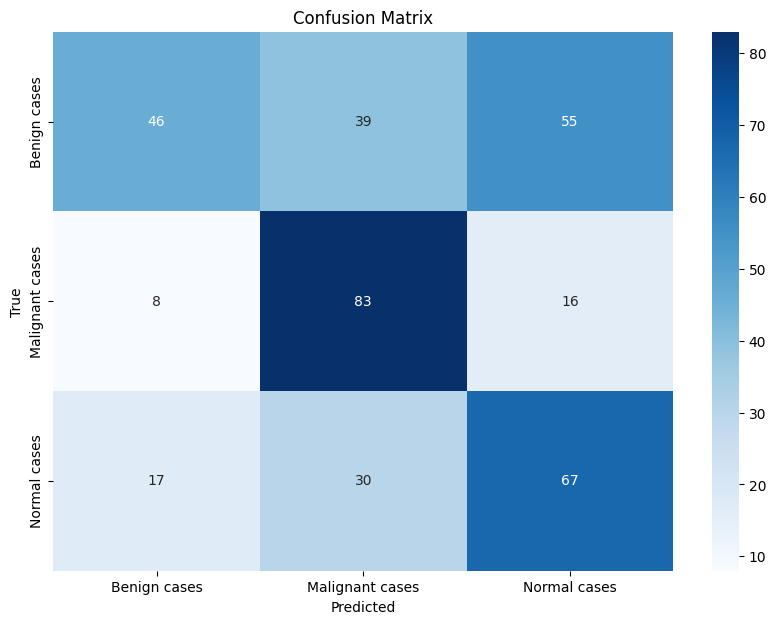

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "resnet_model.h5")
resnet_model.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "resnet_weights.weights.h5")
resnet_model.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = resnet_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Custom CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │       2,986,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,024,771 (11.54 MB)

 Trainable params: 3,024,771 (11.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3227 - loss: 1.1144
Epoch 1: val_loss improved from inf to 1.09861, saving model to best_model1.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 493ms/step - accuracy: 0.3227 - loss: 1.1144 - val_accuracy: 0.3408 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3192 - loss: 1.0986
Epoch 2: val_loss did not improve from 1.09861
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 449ms/step - accuracy: 0.3193 - loss: 1.0986 - val_accuracy: 0.3262 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3388 - loss: 1.0986
Epoch 3: val_loss did not improve from 1.09861
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 433ms/step - accuracy: 0.3388 - loss: 1.0986 - val_accuracy: 0.3262 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.3389 - loss: 1.0986
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 1.09861
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.3388 - loss: 1.

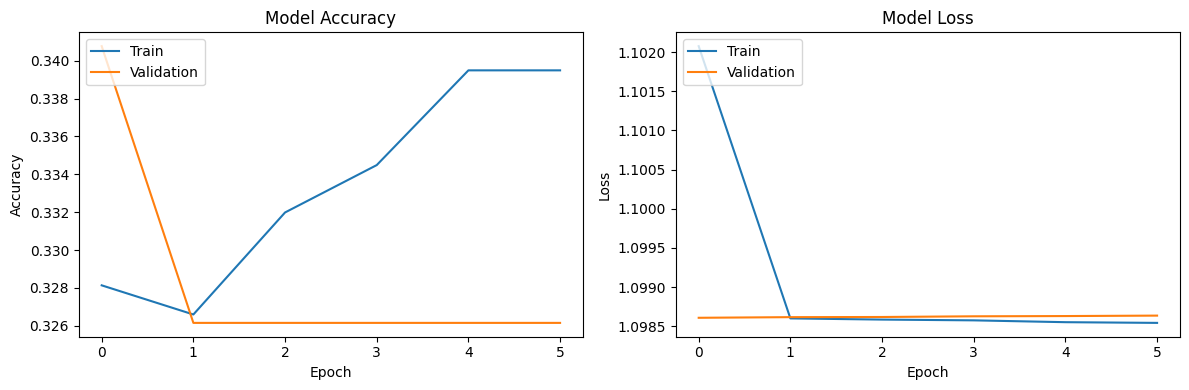

In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(16, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.summary()

model1.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model1.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

test_loss, test_accuracy = model1.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/cnn_model.h5
Trọng số đã lưu tại: /content/drive/MyDrive/DAT/Saved_Models_Segmented/cnn_weights.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.296398891966759
Precision: 0.08785230315912249
Recall: 0.296398891966759
F1-score: 0.13553282666856073


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


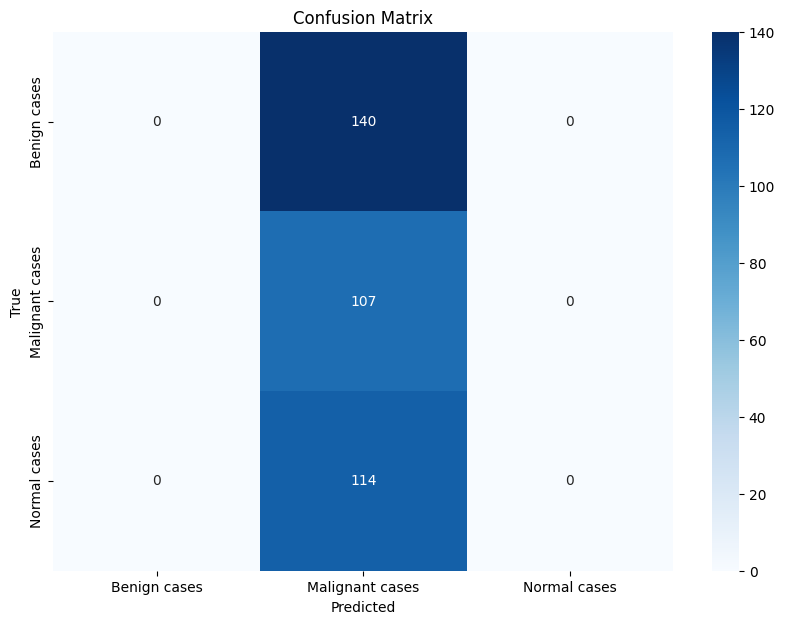

In [ ]:
# Tạo thư mục lưu model trong Google Drive
save_dir = "/content/drive/MyDrive/DAT/Saved_Models_Segmented"
os.makedirs(save_dir, exist_ok=True)

# Lưu toàn bộ model (bao gồm kiến trúc + trọng số)
model_path = os.path.join(save_dir, "cnn_model.h5")
model1.save(model_path)
print(f"Model đã lưu tại: {model_path}")

# Lưu chỉ trọng số (weights)
weights_path = os.path.join(save_dir, "cnn_weights.weights.h5")
model1.save_weights(weights_path)
print(f"Trọng số đã lưu tại: {weights_path}")

# Dự đoán nhãn cho tập test
y_pred = model1.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi từ one-hot encoding về lớp
# Lấy nhãn thực tế từ test_generator
y_true = test_generator.classes
# Tính Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()